<a href="https://colab.research.google.com/github/kyohei-123/autoencoder-test/blob/master/cifar_deep_R1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN with Autoencoder for cifar10

# 0. Introduction
In this notebook, CNN(supervised) and Autoencoder(unsupervised) mixing method is introduced for cifar10 classification. 　　　
<br>
In this notebook, CNN-AE(CNN with autoencoder) and CNN-Base (Basic CNN ) are compared.   
Batch size, epoch, data augmentation and dropout are tested.

Likns below helped me a lot.

Ref1
https://www.tensorflow.org/tutorials/images/cnn  
Ref2 https://deepage.net/deep_learning/2016/10/09/deeplearning_autoencoder.html　　  
Ref3 http://ipr20.cs.ehime-u.ac.jp/column/neural/chapter6.html  
Ref4 https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763　　　<br>
Ref5 https://sefiks.com/2018/03/23/convolutional-autoencoder-clustering-images-with-neural-networks/　　  
Ref6 https://qiita.com/slowsingle/items/bb1671d4a6b19820db5c  

# 1. Data prep

In [115]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from  sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [116]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# https://analytics-note.xyz/machine-learning/keras-check-point/

# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="model-{epoch:02d}-{val_loss:.2f}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )

In [117]:
### Load data

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1aa
train_images, test_images = train_images / 255.0, test_images / 255.0



In [118]:
### Prep data
### In this notebook, number of data are specified as below.
### 2500 training data for bird, deer, truck
### 5000 train data for each remainig 7 class
### 1000 test data for each 10 class

bird_indexes = [i for i, label in enumerate(train_labels) if label==2]
deer_indexes = [i for i, label in enumerate(train_labels) if label==4]
truck_indexes = [i for i, label in enumerate(train_labels) if label==9]
other_indexes = [i for i, label in enumerate(train_labels) if label in (0,1,3,5,6,7,8)] 

train_images_bird, _ = train_test_split(train_images[bird_indexes],train_size=0.5,random_state=0)
train_images_deer, _ = train_test_split(train_images[deer_indexes],train_size=0.5,random_state=0)
train_images_truck, _ = train_test_split(train_images[truck_indexes],train_size=0.5,random_state=0)

train_images = np.vstack([train_images_bird, train_images_deer, train_images_truck, train_images[other_indexes]])
train_labels = np.vstack([(np.ones((2500,1))*2).astype(int), (np.ones((2500,1))*4).astype(int), 
                          (np.ones((2500,1))*9).astype(int), train_labels[other_indexes]])

train_labels_cat = train_labels.copy()
test_labels_cat = test_labels.copy()
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

train_images, train_labels, train_labels_cat = shuffle(train_images, train_labels, train_labels_cat, random_state=0)


print(f"data all # : {train_images.shape}")
print(f"birds data # : {train_images_bird.shape}")
print(f"deers data # : {train_images_deer.shape}")
print(f"trucks data # : {train_images_truck.shape}")
print(f"image.shape = {train_images[0].shape}")

picture_shape = train_images[0].shape



data all # : (42500, 32, 32, 3)
birds data # : (2500, 32, 32, 3)
deers data # : (2500, 32, 32, 3)
trucks data # : (2500, 32, 32, 3)
image.shape = (32, 32, 3)


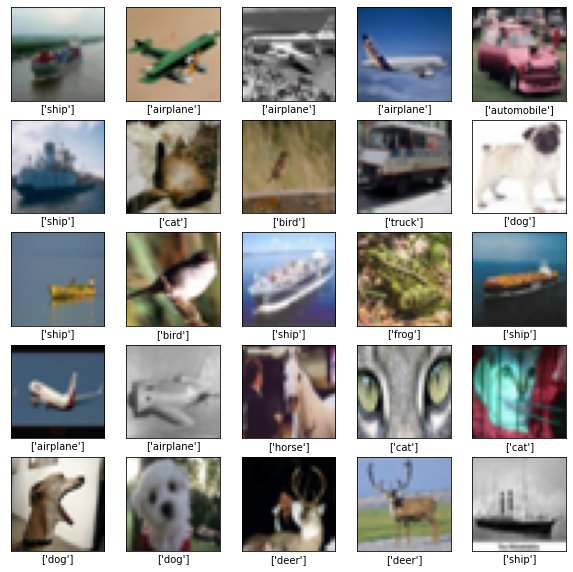

In [119]:
### check labeling

class_names = pd.Series(['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'])

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i].astype(bool)].values)
plt.show()


# 2.1 Autoencoder

In [120]:
### Make autoencoder

### Make encoder
input_img = keras.Input(shape=picture_shape)
x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(input_img)
x = layers.MaxPool2D(pool_size=(2,2))(x)
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)

encoded = x

### Make decoder
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(x)
# x = layers.UpSampling2D(size=(2,2))(x)
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(filters=3, kernel_size=(3, 3), padding='same')(x)

decoded = x

### Combine
autoencoder = keras.Model(inputs=input_img, outputs=decoded)
encoder = keras.Model(inputs=input_img, outputs=encoded)

print(autoencoder.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 8)         584       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 3)         219       
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
_________________________________________________________

In [121]:
### Train autoencoder

# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/ae-{epoch:03d}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )

autoencoder.compile(optimizer='adam',
                    loss=keras.losses.mean_squared_error,
                    metrics=['accuracy'])

history_autoencoder = autoencoder.fit(train_images, train_images,
                epochs=30,
                shuffle=True,
                batch_size=256,
                validation_data=(test_images,test_images),
                callbacks=[checkpoint])


Epoch 1/30
167/167 [==============================] - 35s 207ms/step - loss: 0.1499 - accuracy: 0.2734 - val_loss: 0.0150 - val_accuracy: 0.4159
Epoch 2/30
167/167 [==============================] - 35s 211ms/step - loss: 0.0115 - accuracy: 0.5323 - val_loss: 0.0061 - val_accuracy: 0.6512
Epoch 3/30
167/167 [==============================] - 35s 207ms/step - loss: 0.0056 - accuracy: 0.6727 - val_loss: 0.0044 - val_accuracy: 0.7151
Epoch 4/30
167/167 [==============================] - 35s 212ms/step - loss: 0.0042 - accuracy: 0.7288 - val_loss: 0.0036 - val_accuracy: 0.7391
Epoch 5/30
167/167 [==============================] - 35s 208ms/step - loss: 0.0035 - accuracy: 0.7505 - val_loss: 0.0033 - val_accuracy: 0.7565
Epoch 6/30
167/167 [==============================] - 35s 212ms/step - loss: 0.0032 - accuracy: 0.7642 - val_loss: 0.0030 - val_accuracy: 0.7718
Epoch 7/30
167/167 [==============================] - 33s 199ms/step - loss: 0.0030 - accuracy: 0.7724 - val_loss: 0.0029 - val_ac

Best Validation Loss: 0.0015
Best Validation Accuracy: 0.8371


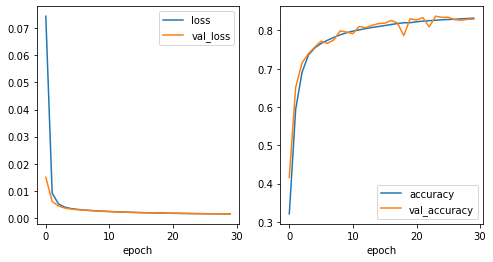

In [122]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_autoencoder_df = pd.DataFrame(history_autoencoder.history)

check_history(history_autoencoder_df)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'autoencodered')

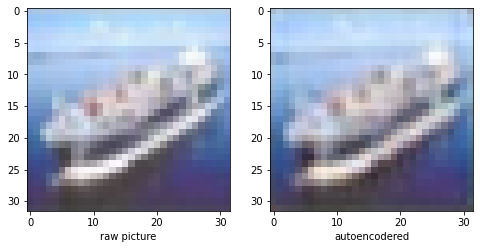

In [123]:
i = 12
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(train_images[i])
plt.xlabel('raw picture')
plt.subplot(1,2,2)
plt.imshow(autoencoder.predict(train_images[[i]]).reshape(32,32,3))
plt.xlabel('autoencodered')



      
      
Ok, seems my autoencoder works well!   
   

# 2.2 CNN with Encoder

In [124]:
### Build CNN with input from encoder

encoder.trainable = False ### I don't want update my trained encoder.

cnn = keras.Sequential()
cnn.add(encoder)
cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D((2,2)))
cnn.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D((2,2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(10))

cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Functional)         (None, 16, 16, 8)         224       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 64)        4672      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

My cnn has 110K trainable parameters. In the following section, my baseline model shoud have same number of parameters so that they are comparable.

In [125]:
# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/cnn_ae0-{epoch:03d}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )

cnn.compile(optimizer = 'adam', 
            loss = keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

history_cnn = cnn.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=30,batch_size=256, shuffle=True,
                     callbacks=[checkpoint])

Epoch 1/30
167/167 [==============================] - 10s 54ms/step - loss: 2.0240 - accuracy: 0.2690 - val_loss: 1.8531 - val_accuracy: 0.3334
Epoch 2/30
167/167 [==============================] - 8s 50ms/step - loss: 1.6069 - accuracy: 0.4268 - val_loss: 1.7979 - val_accuracy: 0.3538
Epoch 3/30
167/167 [==============================] - 11s 65ms/step - loss: 1.4754 - accuracy: 0.4748 - val_loss: 1.5448 - val_accuracy: 0.4482
Epoch 4/30
167/167 [==============================] - 10s 63ms/step - loss: 1.3626 - accuracy: 0.5105 - val_loss: 1.4562 - val_accuracy: 0.4878
Epoch 5/30
167/167 [==============================] - 10s 61ms/step - loss: 1.3044 - accuracy: 0.5371 - val_loss: 1.4046 - val_accuracy: 0.4901
Epoch 6/30
167/167 [==============================] - 10s 62ms/step - loss: 1.2594 - accuracy: 0.5517 - val_loss: 1.5324 - val_accuracy: 0.4575
Epoch 7/30
167/167 [==============================] - 10s 63ms/step - loss: 1.2308 - accuracy: 0.5642 - val_loss: 1.4801 - val_accuracy: 

Best Validation Loss: 1.0312
Best Validation Accuracy: 0.6376


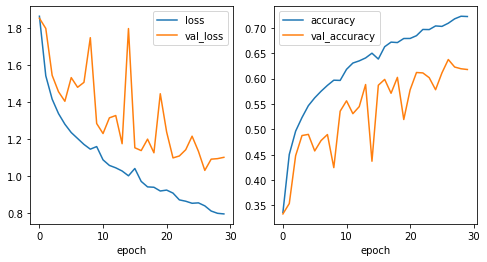

In [126]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_cnn_df = pd.DataFrame(history_cnn.history)

check_history(history_cnn_df)

It seems overfitting started from epoch10. Also the validation score is affected by the choice of data. I will restart training from epoch10 and increase the batch size

In [127]:
cnn = keras.models.load_model("./saved_model/cnn_ae0-010.h5")

# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/cnn_ae1-{epoch:03d}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )

cnn.compile(optimizer = 'adam', 
            loss = keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

history_cnn = cnn.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=20,batch_size=1024, shuffle=True,
                     callbacks=[checkpoint])

Epoch 1/20
42/42 [==============================] - 9s 202ms/step - loss: 1.1341 - accuracy: 0.6061 - val_loss: 1.2018 - val_accuracy: 0.5686
Epoch 2/20
42/42 [==============================] - 8s 198ms/step - loss: 1.0571 - accuracy: 0.6312 - val_loss: 1.2058 - val_accuracy: 0.5679
Epoch 3/20
42/42 [==============================] - 8s 202ms/step - loss: 1.0539 - accuracy: 0.6295 - val_loss: 1.2210 - val_accuracy: 0.5660
Epoch 4/20
42/42 [==============================] - 8s 197ms/step - loss: 1.0379 - accuracy: 0.6389 - val_loss: 1.1886 - val_accuracy: 0.5758
Epoch 5/20
42/42 [==============================] - 8s 196ms/step - loss: 1.0336 - accuracy: 0.6376 - val_loss: 1.1951 - val_accuracy: 0.5731
Epoch 6/20
42/42 [==============================] - 8s 182ms/step - loss: 1.0294 - accuracy: 0.6428 - val_loss: 1.1930 - val_accuracy: 0.5797
Epoch 7/20
42/42 [==============================] - 9s 211ms/step - loss: 1.0026 - accuracy: 0.6508 - val_loss: 1.1479 - val_accuracy: 0.5929
Epoch 

Best Validation Loss: 1.0830
Best Validation Accuracy: 0.6233


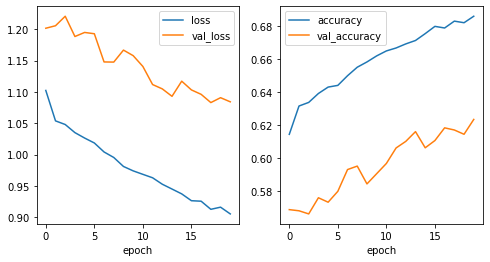

In [128]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_cnn_df = pd.DataFrame(history_cnn.history)

check_history(history_cnn_df)

# 2.3 CNN Baseline

In [129]:
### Check score of baseline model
### I defined my baseline model as below
### Ref: https://www.tensorflow.org/tutorials/images/cnn

basemodel = keras.models.Sequential()
basemodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
basemodel.add(layers.MaxPooling2D((2, 2)))
basemodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
basemodel.add(layers.MaxPooling2D((2, 2)))
basemodel.add(layers.Conv2D(64, (3, 3), activation='relu'))

basemodel.add(layers.Flatten())
basemodel.add(layers.Dense(64, activation='relu'))
basemodel.add(layers.Dense(10))

basemodel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

In my base cnn model above, trainable parameters are 120K, which are almost same for previous cnn with encoder input, which means those models are comparable.

In [130]:
# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/cnn_base0-{epoch:03d}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )

basemodel.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_base = basemodel.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=30,batch_size=256,shuffle=True,
                  callbacks=[checkpoint]
                  )

Epoch 1/30
167/167 [==============================] - 17s 96ms/step - loss: 1.9794 - accuracy: 0.2777 - val_loss: 1.7640 - val_accuracy: 0.3534
Epoch 2/30
167/167 [==============================] - 18s 107ms/step - loss: 1.4781 - accuracy: 0.4715 - val_loss: 1.4042 - val_accuracy: 0.4891
Epoch 3/30
167/167 [==============================] - 18s 107ms/step - loss: 1.3150 - accuracy: 0.5310 - val_loss: 1.3930 - val_accuracy: 0.4941
Epoch 4/30
167/167 [==============================] - 18s 109ms/step - loss: 1.2346 - accuracy: 0.5631 - val_loss: 1.3823 - val_accuracy: 0.5124
Epoch 5/30
167/167 [==============================] - 17s 103ms/step - loss: 1.2036 - accuracy: 0.5731 - val_loss: 1.1989 - val_accuracy: 0.5752
Epoch 6/30
167/167 [==============================] - 18s 106ms/step - loss: 1.1010 - accuracy: 0.6128 - val_loss: 1.2187 - val_accuracy: 0.5690
Epoch 7/30
167/167 [==============================] - 16s 97ms/step - loss: 1.0634 - accuracy: 0.6287 - val_loss: 1.2293 - val_accu

Best Validation Loss: 0.9345
Best Validation Accuracy: 0.6994


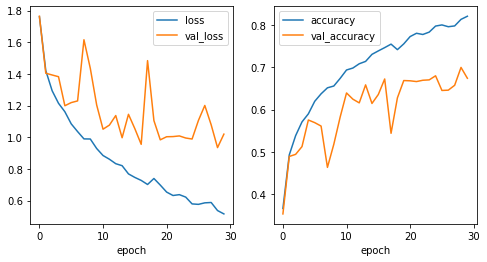

In [131]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))

history_base_df = pd.DataFrame(history_base.history)

check_history(history_base_df)

It is not stable and seems overfitting started from epoch10. I will restart training from epoch 10 and increas batch size

In [132]:
basemodel = keras.models.load_model("./saved_model/cnn_base0-010.h5")

# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/cnn_base1-{epoch:03d}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )

basemodel.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_base = basemodel.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=20,batch_size=1024,shuffle=True,
                  callbacks=[checkpoint]
                  )

Epoch 1/20
42/42 [==============================] - 10s 231ms/step - loss: 1.0012 - accuracy: 0.6510 - val_loss: 0.9911 - val_accuracy: 0.6518
Epoch 2/20
42/42 [==============================] - 10s 236ms/step - loss: 0.8349 - accuracy: 0.7079 - val_loss: 0.9859 - val_accuracy: 0.6570
Epoch 3/20
42/42 [==============================] - 10s 231ms/step - loss: 0.8207 - accuracy: 0.7138 - val_loss: 0.9753 - val_accuracy: 0.6559
Epoch 4/20
42/42 [==============================] - 9s 227ms/step - loss: 0.8113 - accuracy: 0.7148 - val_loss: 0.9764 - val_accuracy: 0.6597
Epoch 5/20
42/42 [==============================] - 9s 226ms/step - loss: 0.8149 - accuracy: 0.7150 - val_loss: 0.9613 - val_accuracy: 0.6652
Epoch 6/20
42/42 [==============================] - 10s 233ms/step - loss: 0.7824 - accuracy: 0.7279 - val_loss: 0.9790 - val_accuracy: 0.6581
Epoch 7/20
42/42 [==============================] - 10s 227ms/step - loss: 0.7708 - accuracy: 0.7313 - val_loss: 0.9593 - val_accuracy: 0.6646
E

Best Validation Loss: 0.9184
Best Validation Accuracy: 0.6938


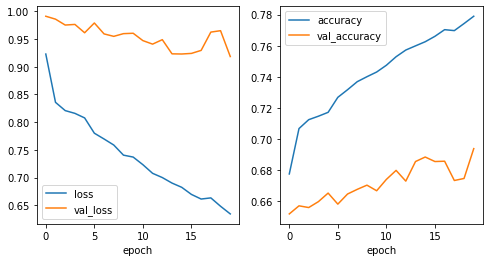

In [133]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))

history_base_df = pd.DataFrame(history_base.history)

check_history(history_base_df)

The gap between the training loss and test loss is getting wider, suggesting overfitting to training data.

# 2.4 Evaluate result

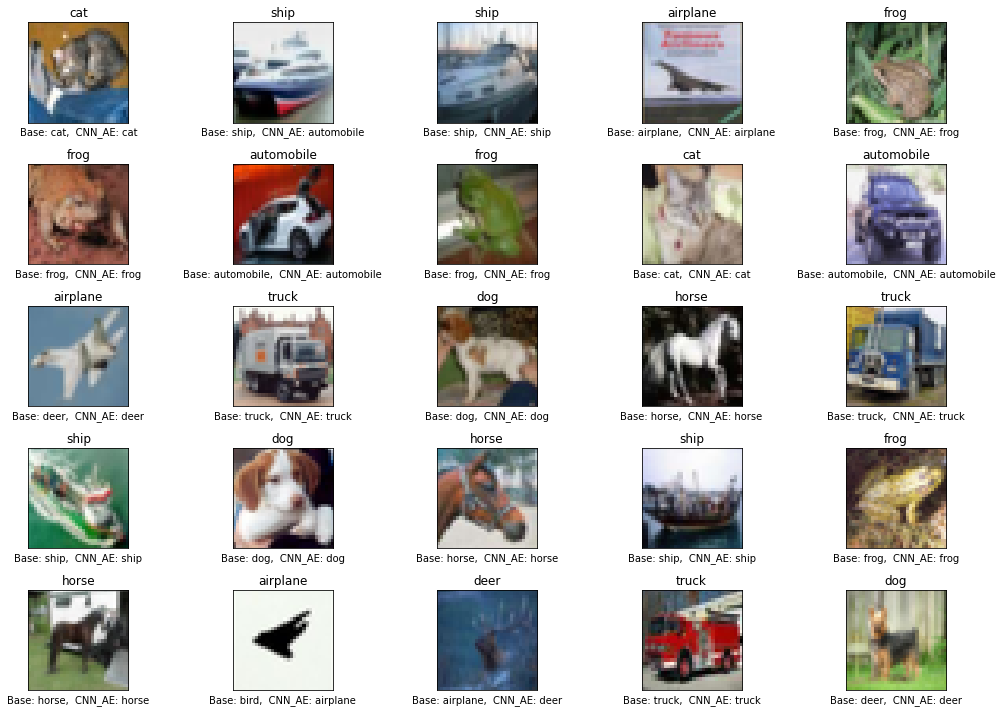

In [134]:
# i = 6
plt.figure(figsize=(15,10),tight_layout=True)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(test_images[i])
    res_base = class_names[np.argmax(basemodel.predict(test_images[[i]]))]
    res_cnn = class_names[np.argmax(cnn.predict(test_images[[i]]))]
    plt.xlabel(f"Base: {res_base},  CNN_AE: {res_cnn}")
    plt.title(class_names[np.argmax(test_labels[i])])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

In [135]:
test_pred_cnn = cnn.predict(test_images)
test_pred_basemodel = basemodel.predict(test_images)

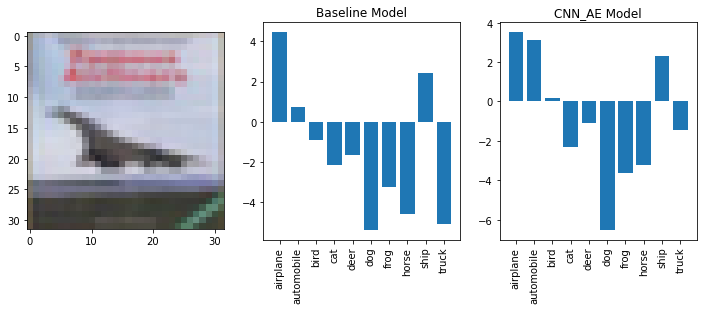

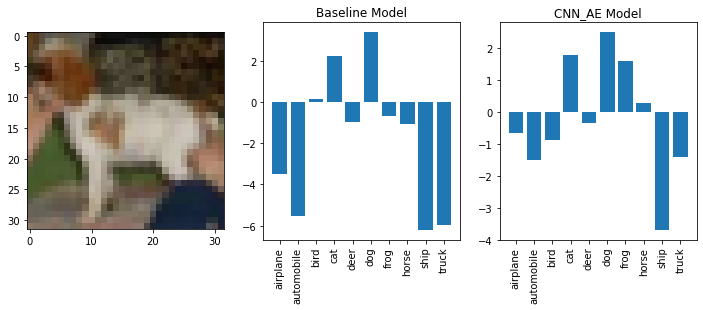

In [136]:
### Check how much confident my models predict each test data

i=3
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(test_images[i])
plt.subplot(1,3,2)
plt.bar(x = class_names, height = test_pred_basemodel[i])
plt.xticks(rotation=90)
plt.title('Baseline Model')
plt.subplot(1,3,3)
plt.bar(x = class_names, height = test_pred_cnn[i])
plt.xticks(rotation=90)
plt.title('CNN_AE Model')
plt.show()

i=12
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(test_images[i])
plt.subplot(1,3,2)
plt.bar(x = class_names, height = test_pred_basemodel[i])
plt.xticks(rotation=90)
plt.title('Baseline Model')
plt.subplot(1,3,3)
plt.bar(x = class_names, height = test_pred_cnn[i])
plt.xticks(rotation=90)
plt.title('CNN_AE Model')
plt.show()

Ah, ok my models can distinguish between "animal" and "machine", but diffcult to tell which "machine" or which "animal" it is. 

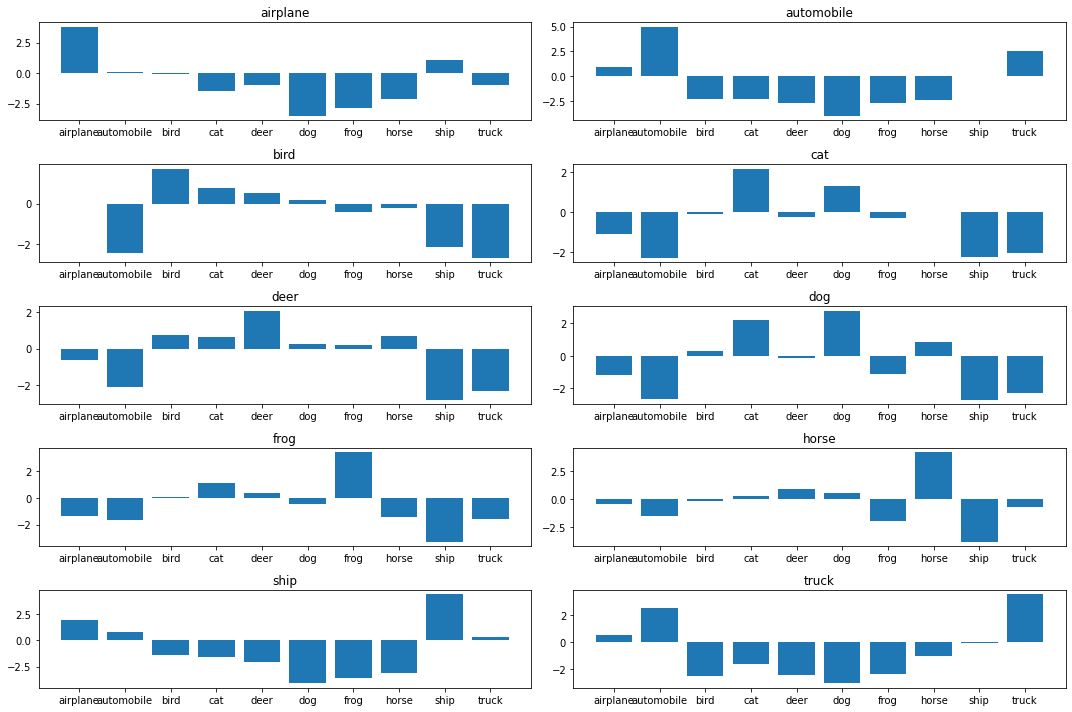

In [137]:
### Check how much confident my models predict each test data

result_df = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df = pd.concat([result_df, pd.DataFrame(test_pred_cnn,columns = class_names)],axis=1)

# label = "airplane"
plt.figure(figsize=(15,10),tight_layout=True)
for i,label in enumerate(class_names):
    filter = result_df[label+"_label"]==1
    plt.subplot(5,2,i+1)
    plt.bar(x=class_names, height = result_df[filter][class_names].mean())
    plt.title(label)

Ok, my model has difficulty to distinguish bird, cat, dog and deer. Maybe I can improve my model by augmenting data. I hope I can improve my model for deer since they have distinct feature.

# 3. Data augmentation

Since the animals are hard to tell which is which, I introduce data augmentation to train my model more.

# 3.1 Data augmentation

In [138]:
### Data augmentation (2times of bird, dog, cat and deer)
### In animal pictures, many pausings can be found. Therefore, animal's rotation will not be important feature, so I will augment animal pictures by rotation.


def func_augment(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # ImageDataGeneratorの生成
    datagen = ImageDataGenerator(
        rotation_range=30
    )

    g = datagen.flow(x, batch_size=1)
    batch=[]
    for i in range(1):
        batch.append(g.next())
    return batch
# i = 0
# x = train_images[i]
# y = func_augment(x)[0]

In [139]:
### bird
filter = np.where(train_labels_cat==2)[0]
bird_adds = func_augment(train_images[filter][0])[0]
for img in train_images[filter][1:]:
    bird_adds = np.vstack((bird_adds,func_augment(img)[0]))

### cat
filter = np.where(train_labels_cat==3)[0]
cat_adds = func_augment(train_images[filter][0])[0]
for img in train_images[filter][1:]:
    cat_adds = np.vstack((cat_adds,func_augment(img)[0]))

### deer
filter = np.where(train_labels_cat==4)[0]
deer_adds = func_augment(train_images[filter][0])[0]
for img in train_images[filter][1:]:
    deer_adds = np.vstack((deer_adds,func_augment(img)[0]))

### dog
filter = np.where(train_labels_cat==5)[0]
dog_adds = func_augment(train_images[filter][0])[0]
for img in train_images[filter][1:]:
    dog_adds = np.vstack((dog_adds,func_augment(img)[0]))

In [140]:
train_images = np.vstack([train_images,bird_adds,cat_adds,deer_adds,dog_adds])
train_labels_cat = np.vstack([train_labels_cat, (np.ones((2500,1))*2).astype(int), (np.ones((5000,1))*3).astype(int), 
                          (np.ones((2500,1))*4).astype(int), (np.ones((5000,1))*5).astype(int)])

In [141]:
train_labels = keras.utils.to_categorical(train_labels_cat, 10)
train_images, train_labels, train_labels_cat = shuffle(train_images, train_labels, train_labels_cat, random_state=0)

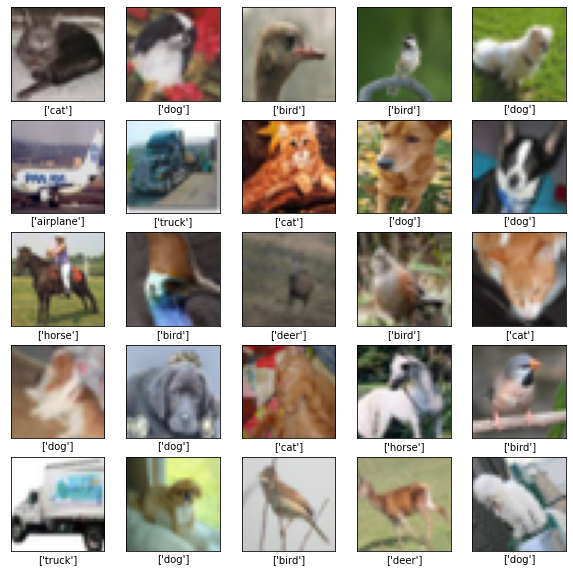

In [142]:
### check labeling

class_names = pd.Series(['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'])

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i].astype(bool)].values)
plt.show()


# 3.2 Training with augmented data
## 3.2.1 CNN with Autoencoder

Epoch 1/30
57/57 [==============================] - 11s 192ms/step - loss: 1.0587 - accuracy: 0.6253 - val_loss: 1.0687 - val_accuracy: 0.6229
Epoch 2/30
57/57 [==============================] - 11s 199ms/step - loss: 0.9578 - accuracy: 0.6573 - val_loss: 1.1021 - val_accuracy: 0.6114
Epoch 3/30
57/57 [==============================] - 11s 199ms/step - loss: 0.9561 - accuracy: 0.6561 - val_loss: 1.0958 - val_accuracy: 0.6120
Epoch 4/30
57/57 [==============================] - 11s 188ms/step - loss: 0.9443 - accuracy: 0.6603 - val_loss: 1.0825 - val_accuracy: 0.6168
Epoch 5/30
57/57 [==============================] - 11s 198ms/step - loss: 0.9403 - accuracy: 0.6586 - val_loss: 1.0532 - val_accuracy: 0.6285
Epoch 6/30
57/57 [==============================] - 11s 194ms/step - loss: 0.9210 - accuracy: 0.6674 - val_loss: 1.0454 - val_accuracy: 0.6335
Epoch 7/30
57/57 [==============================] - 11s 191ms/step - loss: 0.9110 - accuracy: 0.6737 - val_loss: 1.0823 - val_accuracy: 0.6202

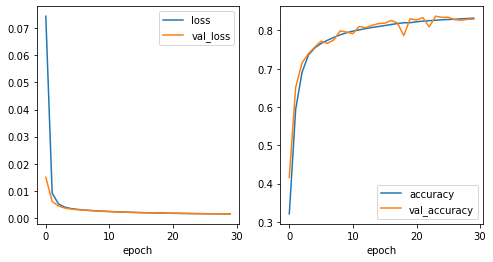

In [143]:
# CNN with Autoencoder with augmented data

cnn = keras.models.load_model("./saved_model/cnn_ae1-020.h5")

# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/cnn_ae_aug-{epoch:03d}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )

### CNN with Autoencoder

cnn.compile(optimizer = 'adam', 
            loss = keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

history_cnn = cnn.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=30,batch_size=1024, shuffle=True,
                    callbacks=[checkpoint])


### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_autoencoder_df = pd.DataFrame(history_autoencoder.history)

check_history(history_autoencoder_df)

## 3.2.2 Baseline CNN model

Epoch 1/30
57/57 [==============================] - 14s 229ms/step - loss: 0.8727 - accuracy: 0.6945 - val_loss: 0.9100 - val_accuracy: 0.6898
Epoch 2/30
57/57 [==============================] - 12s 216ms/step - loss: 0.7029 - accuracy: 0.7480 - val_loss: 0.9211 - val_accuracy: 0.6910
Epoch 3/30
57/57 [==============================] - 12s 203ms/step - loss: 0.7020 - accuracy: 0.7492 - val_loss: 0.9213 - val_accuracy: 0.6894
Epoch 4/30
57/57 [==============================] - 13s 226ms/step - loss: 0.6988 - accuracy: 0.7497 - val_loss: 0.9031 - val_accuracy: 0.6915
Epoch 5/30
57/57 [==============================] - 13s 224ms/step - loss: 0.6928 - accuracy: 0.7505 - val_loss: 0.9147 - val_accuracy: 0.6888
Epoch 6/30
57/57 [==============================] - 13s 220ms/step - loss: 0.6827 - accuracy: 0.7571 - val_loss: 0.9190 - val_accuracy: 0.6895
Epoch 7/30
57/57 [==============================] - 12s 214ms/step - loss: 0.6742 - accuracy: 0.7588 - val_loss: 0.9216 - val_accuracy: 0.6957

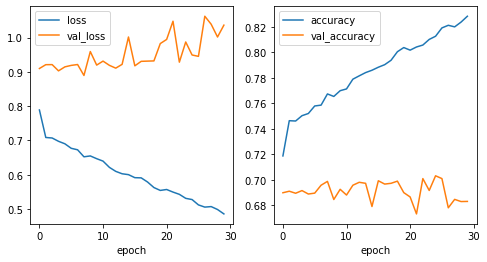

In [144]:
### Baseline CNN

basemodel = keras.models.load_model("./saved_model/cnn_base1-020.h5")

# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/cnn_base_aug-{epoch:03d}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )


basemodel.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_base = basemodel.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=30,batch_size=1024,shuffle=True,
                  callbacks=[checkpoint]
                  )



### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))

history_base_df = pd.DataFrame(history_base.history)

check_history(history_base_df)

Oh, now baseline model didn't imporove. Larger gap suggests over fitting.
On the other hand, cnn_ae improved a lot, the learning curves between training and test stay consistent, which could be the benefit from encoder where only feature are extracted so my model was not affected by noise!

# 3.3 Evaluate Results

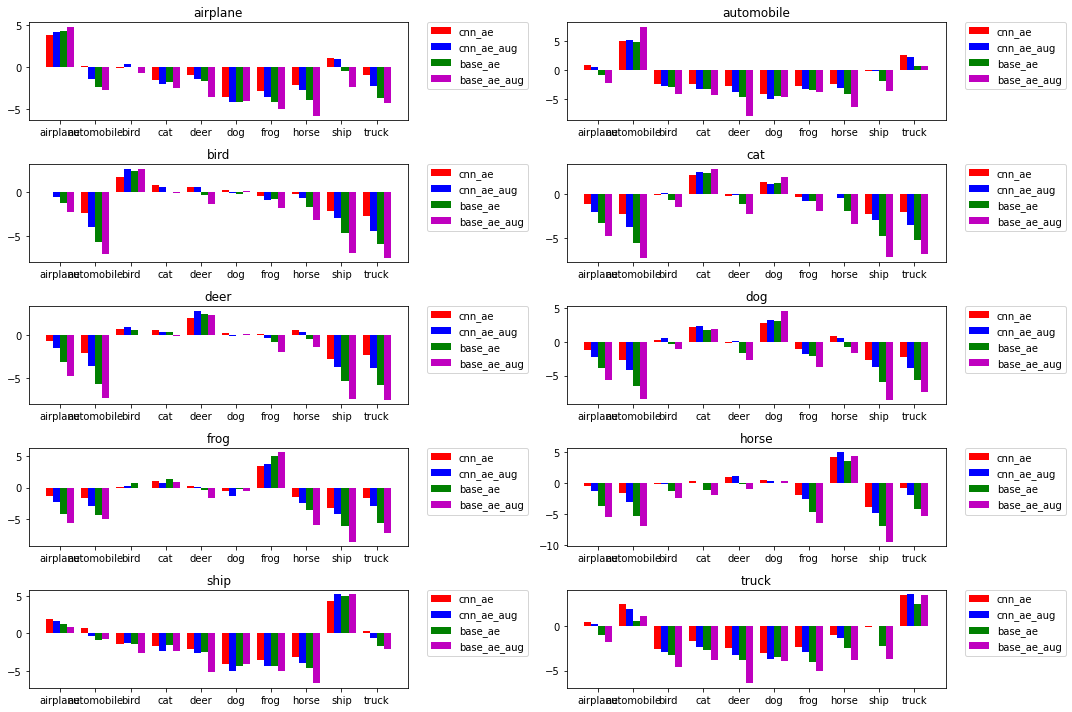

In [145]:
### Check how much confident my models predict each test data

cnn1 = keras.models.load_model("./saved_model/cnn_ae1-020.h5")
cnn2 = keras.models.load_model("./saved_model/cnn_ae_aug-030.h5")
cnn3 = keras.models.load_model("./saved_model/cnn_base1-020.h5")
cnn4 = keras.models.load_model("./saved_model/cnn_base_aug-030.h5")

test_pred_cnn1 = cnn1.predict(test_images)
test_pred_cnn2 = cnn2.predict(test_images)
test_pred_cnn3 = cnn3.predict(test_images)
test_pred_cnn4 = cnn4.predict(test_images)

result_df1 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df2 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df3 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df4 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df1 = pd.concat([result_df1, pd.DataFrame(test_pred_cnn1,columns = class_names)],axis=1)
result_df2 = pd.concat([result_df2, pd.DataFrame(test_pred_cnn2,columns = class_names)],axis=1)
result_df3 = pd.concat([result_df3, pd.DataFrame(test_pred_cnn3,columns = class_names)],axis=1)
result_df4 = pd.concat([result_df4, pd.DataFrame(test_pred_cnn4,columns = class_names)],axis=1)

plt.figure(figsize=(15,10),tight_layout=True)
for i, label in enumerate(class_names):
    filter = result_df1[label+'_label']==1
    h1 = result_df1[filter][class_names].mean()
    h2 = result_df2[filter][class_names].mean()
    h3 = result_df3[filter][class_names].mean()
    h4 = result_df4[filter][class_names].mean()
    plt.subplot(5,2,i+1)
    plt.bar(x=np.arange(0,10,1),height=h1.values,width=0.2,color='r',label="cnn_ae")
    plt.bar(x=np.arange(0,10,1)+0.2, height=h2.values, width=0.2,color='b',label="cnn_ae_aug")
    plt.bar(x=np.arange(0,10,1)+0.4, height=h3.values, width=0.2,color='g',label="base_ae")
    plt.bar(x=np.arange(0,10,1)+0.6, height=h4.values, width=0.2,color='m',label="base_ae_aug")
    plt.xticks(ticks=np.arange(0,10,1)+0.3, labels=class_names)
    plt.title(label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()
    
# label = "airplane"
# plt.figure(figsize=(15,10),tight_layout=True)
# for i,label in enumerate(class_names):
#     filter = result_df1[label+"_label"]==1
#     plt.subplot(5,2,i+1)
#     plt.bar(x=class_names, height = result_df1[filter][class_names].mean())
#     plt.title(label)

On the whole, cnn_ae_aug (CNN with Autoencoder with augmented data) shows better classification peformance. But still cat and dog is difficult to distinguish.

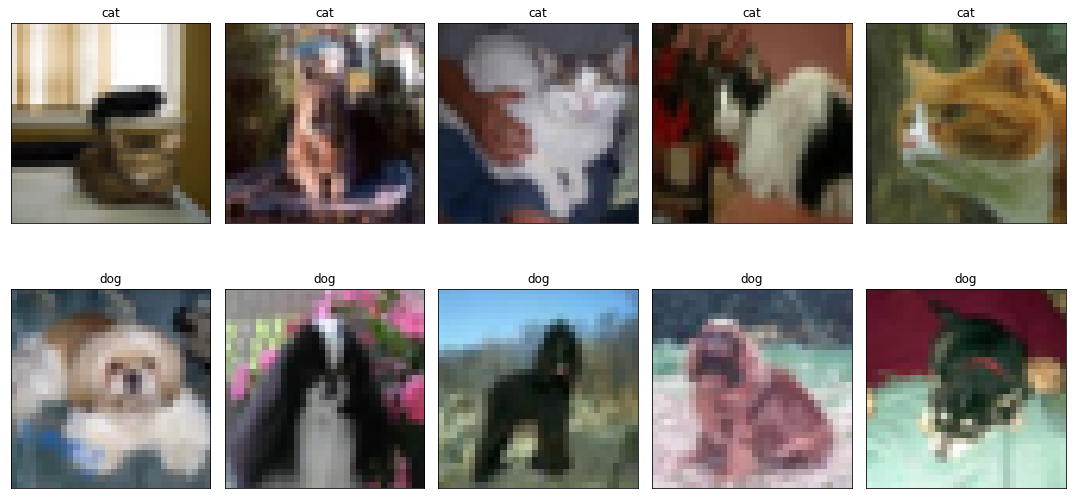

In [146]:
### I want to check how the cats and dogs look like to get modeling idea.
plt.figure(figsize=(15,8),tight_layout=True)
for i,img in enumerate(test_images[np.where(test_labels_cat==3)[0]][5:10]):
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title("cat")
for i,img in enumerate(test_images[np.where(test_labels_cat==5)[0]][5:10]):
    plt.subplot(2,5,i+6)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title("dog")

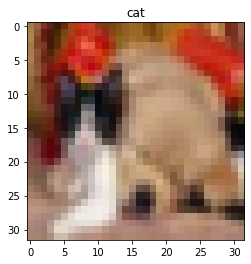

In [147]:
### Most dog like cat
filter = result_df2["cat_label"]==1
idx = result_df2[filter]['dog'].idxmax()
plt.imshow(test_images[idx])
plt.title(class_names[test_labels_cat[idx][0]])
plt.show()

For example, this dog-like-cat is difficult to tell.

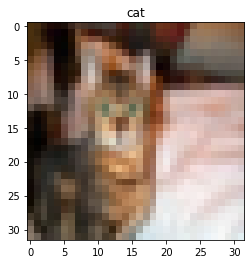

In [148]:
### Most cat like cat
filter = result_df2["cat_label"]==1
idx = result_df2[filter]['cat'].idxmax()
plt.imshow(test_images[idx])
plt.title(class_names[test_labels_cat[idx][0]])
plt.show()

Understandable.

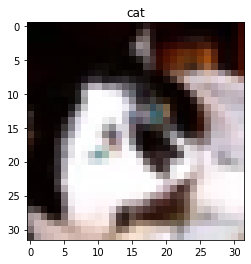

In [149]:
### Cat with most gap (dog-cat)
filter = result_df2["cat_label"]==1
idx = (result_df2[filter]['dog']-result_df2[filter]['cat']).idxmax()
plt.imshow(test_images[idx])
plt.title(class_names[test_labels_cat[idx][0]])
plt.show()

This is not a good data. cifar10 has this kind of difficult test data. 

# 4. Dropout   
Since my baseline CNN model seems overfitting training data, I am interested to try dropout to mitigate overfitting and increase epochs in the same time to distinguish cat and dog.

## 4.1 CNN with autoencoder with augmented data with dropout

In [150]:
### Build CNN with input from encoder and dropout

encoder.trainable = False ### I don't want update my trained encoder.

cnn = keras.Sequential()
cnn.add(encoder)
cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D((2,2)))
cnn.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D((2,2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dropout(0.25))
cnn.add(layers.Dense(10))

cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Functional)         (None, 16, 16, 8)         224       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 14, 64)        4672      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)               

In [151]:
# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/cnn_ae_aug_drop-{epoch:03d}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )

cnn.compile(optimizer = 'adam', 
            loss = keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

history_cnn = cnn.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=50,batch_size=1024, shuffle=True,
                     callbacks=[checkpoint])
# cnn.save('./saved_model/cnn_aug_drop.h5')

Epoch 1/50
57/57 [==============================] - 12s 195ms/step - loss: 2.1915 - accuracy: 0.1819 - val_loss: 2.0103 - val_accuracy: 0.2652
Epoch 2/50
57/57 [==============================] - 11s 201ms/step - loss: 1.8949 - accuracy: 0.3028 - val_loss: 1.8118 - val_accuracy: 0.3416
Epoch 3/50
57/57 [==============================] - 11s 187ms/step - loss: 1.7151 - accuracy: 0.3667 - val_loss: 1.6953 - val_accuracy: 0.3772
Epoch 4/50
57/57 [==============================] - 11s 200ms/step - loss: 1.6176 - accuracy: 0.4011 - val_loss: 1.6065 - val_accuracy: 0.4168
Epoch 5/50
57/57 [==============================] - 11s 199ms/step - loss: 1.5538 - accuracy: 0.4264 - val_loss: 1.5494 - val_accuracy: 0.4432
Epoch 6/50
57/57 [==============================] - 11s 190ms/step - loss: 1.5124 - accuracy: 0.4417 - val_loss: 1.5324 - val_accuracy: 0.4414
Epoch 7/50
57/57 [==============================] - 10s 182ms/step - loss: 1.4767 - accuracy: 0.4544 - val_loss: 1.4969 - val_accuracy: 0.4578

Best Validation Loss: 1.1219
Best Validation Accuracy: 0.5977


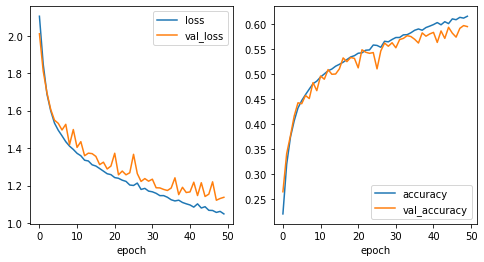

In [152]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_cnn_df = pd.DataFrame(history_cnn.history)

check_history(history_cnn_df)

Learning curve seems good!

## 4.2 Baseline CNN model with augmented data with dropout

In [153]:
### Ref: https://www.tensorflow.org/tutorials/images/cnn

basemodel = keras.models.Sequential()
basemodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
basemodel.add(layers.MaxPooling2D((2, 2)))
basemodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
basemodel.add(layers.MaxPooling2D((2, 2)))
basemodel.add(layers.Conv2D(64, (3, 3), activation='relu'))

basemodel.add(layers.Flatten())
basemodel.add(layers.Dense(64, activation='relu'))
basemodel.add(layers.Dropout(0.25))
basemodel.add(layers.Dense(10))

basemodel.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)               

In [154]:
# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/cnn_base_aug_drop-{epoch:03d}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )


basemodel.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_base = basemodel.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=50,batch_size=1024,shuffle=True,
                    callbacks=[checkpoint]
#                   callbacks=[early_stopping]
                  )
# basemodel.save('./saved_model/basemodel_aug_drop.h5')

Epoch 1/50
57/57 [==============================] - 13s 214ms/step - loss: 2.1463 - accuracy: 0.2061 - val_loss: 1.8223 - val_accuracy: 0.3401
Epoch 2/50
57/57 [==============================] - 12s 219ms/step - loss: 1.7404 - accuracy: 0.3480 - val_loss: 1.6535 - val_accuracy: 0.3887
Epoch 3/50
57/57 [==============================] - 13s 220ms/step - loss: 1.5693 - accuracy: 0.4155 - val_loss: 1.5521 - val_accuracy: 0.4372
Epoch 4/50
57/57 [==============================] - 12s 217ms/step - loss: 1.4845 - accuracy: 0.4486 - val_loss: 1.4345 - val_accuracy: 0.4832
Epoch 5/50
57/57 [==============================] - 12s 213ms/step - loss: 1.4204 - accuracy: 0.4807 - val_loss: 1.4174 - val_accuracy: 0.4956
Epoch 6/50
57/57 [==============================] - 12s 211ms/step - loss: 1.3425 - accuracy: 0.5094 - val_loss: 1.3339 - val_accuracy: 0.5251
Epoch 7/50
57/57 [==============================] - 12s 217ms/step - loss: 1.3073 - accuracy: 0.5197 - val_loss: 1.3092 - val_accuracy: 0.5311

Best Validation Loss: 0.8837
Best Validation Accuracy: 0.6948


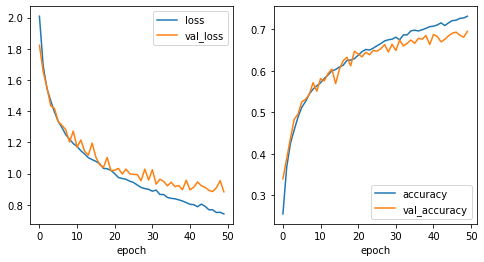

In [155]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_base_df = pd.DataFrame(history_base.history)

check_history(history_base_df)

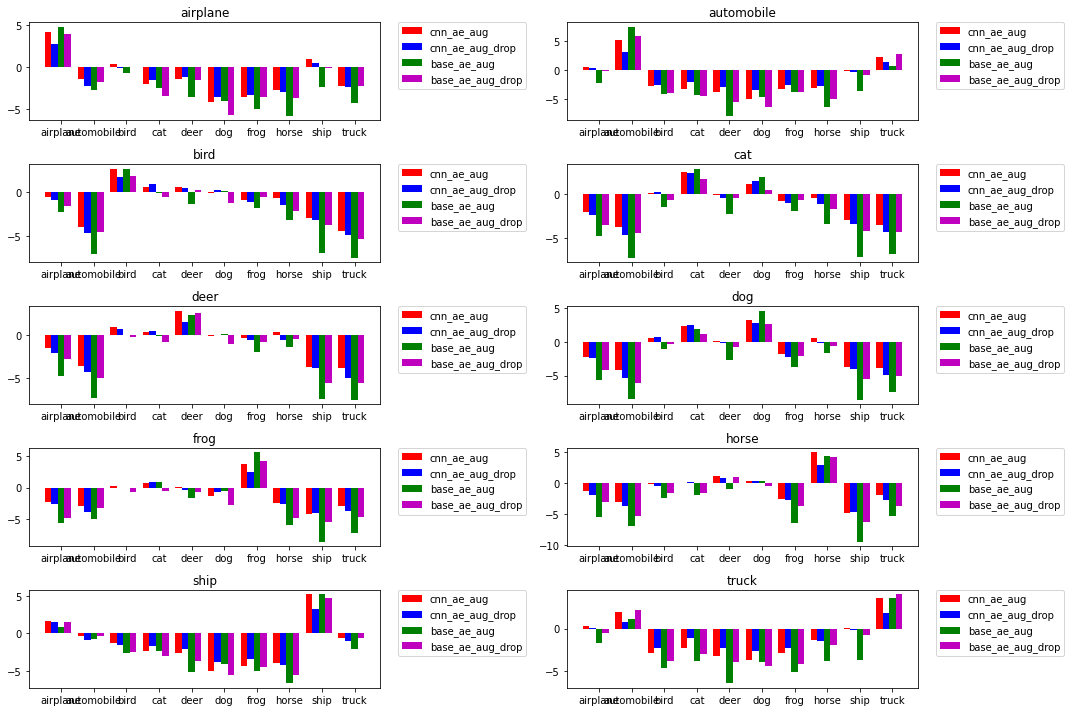

In [156]:
### Check how much confident my models predict each test data

cnn1 = keras.models.load_model("./saved_model/cnn_ae_aug-030.h5")
cnn2 = keras.models.load_model("./saved_model/cnn_ae_aug_drop-050.h5")
cnn3 = keras.models.load_model("./saved_model/cnn_base_aug-030.h5")
cnn4 = keras.models.load_model("./saved_model/cnn_base_aug_drop-050.h5")

test_pred_cnn1 = cnn1.predict(test_images)
test_pred_cnn2 = cnn2.predict(test_images)
test_pred_cnn3 = cnn3.predict(test_images)
test_pred_cnn4 = cnn4.predict(test_images)

result_df1 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df2 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df3 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df4 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df1 = pd.concat([result_df1, pd.DataFrame(test_pred_cnn1,columns = class_names)],axis=1)
result_df2 = pd.concat([result_df2, pd.DataFrame(test_pred_cnn2,columns = class_names)],axis=1)
result_df3 = pd.concat([result_df3, pd.DataFrame(test_pred_cnn3,columns = class_names)],axis=1)
result_df4 = pd.concat([result_df4, pd.DataFrame(test_pred_cnn4,columns = class_names)],axis=1)

plt.figure(figsize=(15,10),tight_layout=True)
for i, label in enumerate(class_names):
    filter = result_df1[label+'_label']==1
    h1 = result_df1[filter][class_names].mean()
    h2 = result_df2[filter][class_names].mean()
    h3 = result_df3[filter][class_names].mean()
    h4 = result_df4[filter][class_names].mean()
    plt.subplot(5,2,i+1)
    plt.bar(x=np.arange(0,10,1),height=h1.values,width=0.2,color='r',label="cnn_ae_aug")
    plt.bar(x=np.arange(0,10,1)+0.2, height=h2.values, width=0.2,color='b',label="cnn_ae_aug_drop")
    plt.bar(x=np.arange(0,10,1)+0.4, height=h3.values, width=0.2,color='g',label="base_ae_aug")
    plt.bar(x=np.arange(0,10,1)+0.6, height=h4.values, width=0.2,color='m',label="base_ae_aug_drop")
    plt.xticks(ticks=np.arange(0,10,1)+0.4, labels=class_names)
    plt.title(label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()
    
# label = "airplane"
# plt.figure(figsize=(15,10),tight_layout=True)
# for i,label in enumerate(class_names):
#     filter = result_df1[label+"_label"]==1
#     plt.subplot(5,2,i+1)
#     plt.bar(x=class_names, height = result_df1[filter][class_names].mean())
#     plt.title(label)

Text(0.5, 1.0, 'Model prediction to 1000 dog images')

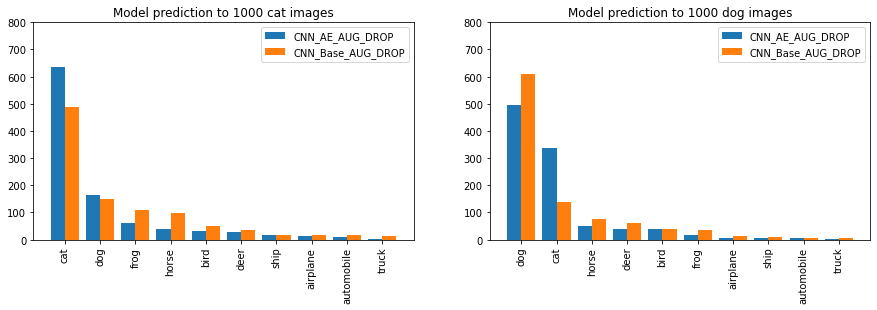

In [158]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
filter = result_df2['cat_label']==1
data2 = result_df2[filter][class_names].idxmax(axis=1).value_counts()
filter = result_df4['cat_label']==1
data4 = result_df4[filter][class_names].idxmax(axis=1).value_counts()
plt.bar(x = np.arange(0,10,1), height = data2.values, width=0.4, label="CNN_AE_AUG_DROP")
plt.bar(x = np.arange(0,10,1)+0.4, height = data4.values, width=0.4, label="CNN_Base_AUG_DROP")
plt.xticks(ticks=np.arange(0,10,1)+0.2, labels=data2.keys())
plt.xticks(rotation=90)
plt.legend()
plt.ylim(0,800)
plt.title(f"Model prediction to {len(result_df2[filter])} cat images")

plt.subplot(1,2,2)
filter = result_df2['dog_label']==1
data2 = result_df2[filter][class_names].idxmax(axis=1).value_counts()
filter = result_df4['dog_label']==1
data4 = result_df4[filter][class_names].idxmax(axis=1).value_counts()
plt.bar(x = np.arange(0,10,1), height = data2.values, width=0.4, label="CNN_AE_AUG_DROP")
plt.bar(x = np.arange(0,10,1)+0.4, height = data4.values, width=0.4, label="CNN_Base_AUG_DROP")
plt.xticks(ticks=np.arange(0,10,1)+0.2, labels=data2.keys())
plt.xticks(rotation=90)
plt.legend()
plt.ylim(0,800)
plt.title(f"Model prediction to {len(result_df2[filter])} dog images")

Basic CNN has more better score in predicting dog in dog images, while CNN-AE mis-predicts dog images as cat more than 300 times. It could be because the autoencoder lost the essential images to distinguish cats and dogs.

# 5. Conclusion



In [159]:
models = []
models.append(keras.models.load_model("./saved_model/cnn_ae1-020.h5"))
models.append(keras.models.load_model("./saved_model/cnn_ae_aug-030.h5"))
models.append(keras.models.load_model("./saved_model/cnn_ae_aug_drop-050.h5"))
models.append(keras.models.load_model("./saved_model/cnn_base1-020.h5"))
models.append(keras.models.load_model("./saved_model/cnn_base_aug-030.h5"))
models.append(keras.models.load_model("./saved_model/cnn_base_aug_drop-050.h5"))

test_losses = []
test_accs = []
for model in models:
    loss, acc = model.evaluate(test_images, test_labels, verbose=0)
    test_losses.append(loss)
    test_accs.append(acc)


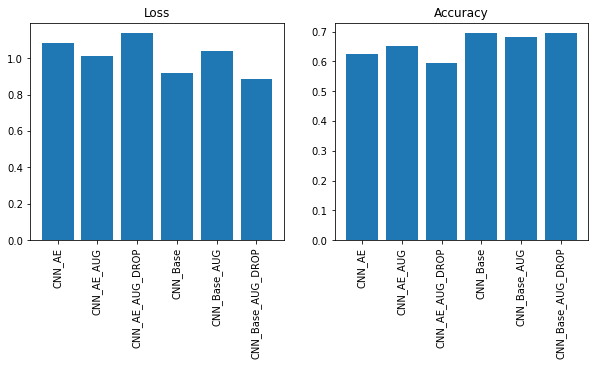

In [160]:
### Summary of the my models.

model_labels = ["CNN_AE", "CNN_AE_AUG", "CNN_AE_AUG_DROP","CNN_Base", "CNN_Base_AUG", "CNN_Base_AUG_DROP"]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(x=np.arange(0,len(model_labels),1), height=test_losses)
plt.xticks(ticks = np.arange(0,len(model_labels),1), labels = model_labels)
plt.xticks(rotation=90)
plt.title("Loss")

plt.subplot(1,2,2)
plt.bar(x=np.arange(0,len(model_labels),1), height=test_accs)
plt.xticks(ticks = np.arange(0,len(model_labels),1), labels = model_labels)
plt.xticks(rotation=90)
plt.title("Accuracy")

plt.show()

In conclusion, basic CNN model showed better peformance compared to CNN with encoder.   
In this classificatioin problem, dogs and cats are difficult to distinguish. It would be understandable that autoencoder lost essential information to distinguish dogs and cats. Therefore it would be good to use basic CNN with more epochs to fit details and in the same time more augmented data to avoid overfitting.